In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import sklearn
import matplotlib


In [2]:
matplotlib.rcParams.update({
    'font.size':18,
    'legend.fontsize':20,
    'axes.labelsize':12,
    'figure.titlesize':22,
    'lines.linewidth': 2.5,
    'lines.markersize': 12.0
})
#matplotlib.rcParams

In [3]:
from data import *

In [4]:
print(daily_diff.tolist())
seperate_daily_diff = np.sum([from_hospitals, from_travel, new_cases], dtype='intc', axis=0)
print(seperate_daily_diff.tolist())
if(np.sum(np.diff([daily_diff,seperate_daily_diff],axis=0)) != 0):
    print("Error: seperate new cases and total new cases do not match")

[0, 2, 0, 4, 4, 11, 5, 7, 13, 3, 9, 9, 8, 9, 11, 21, 8, 8, 14, 16, 17, 35, 16, 32]
[0, 2, 0, 4, 4, 11, 5, 7, 13, 3, 9, 9, 8, 9, 11, 21, 8, 8, 14, 16, 17, 35, 16, 32]


## Total Cases

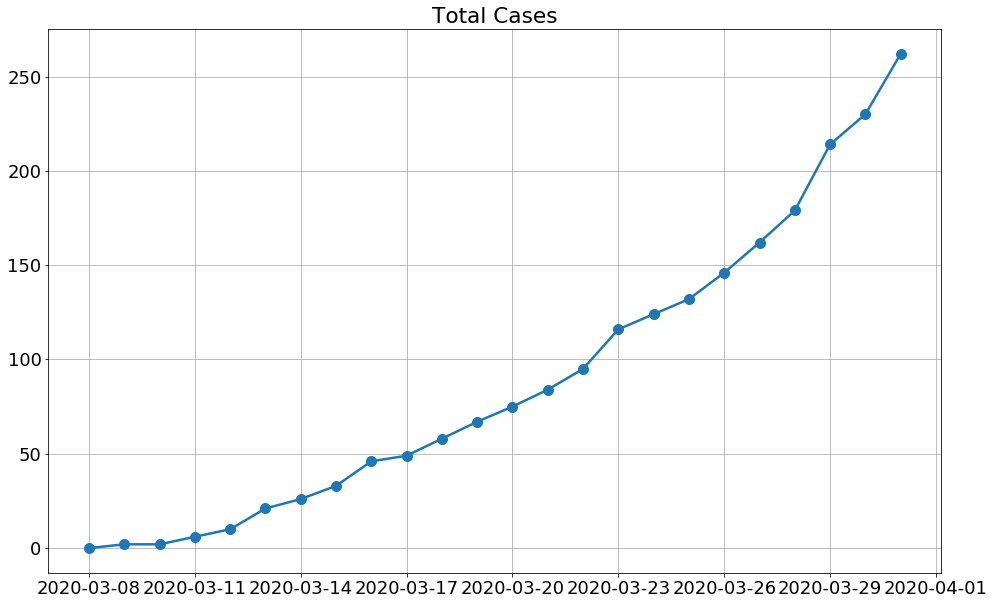

In [5]:
fig = plt.figure(figsize=(16,10))
plt.plot(dates, total_cases, marker="o", markersize=10, linewidth=2.5)
plt.title('Total Cases')
plt.grid(True)

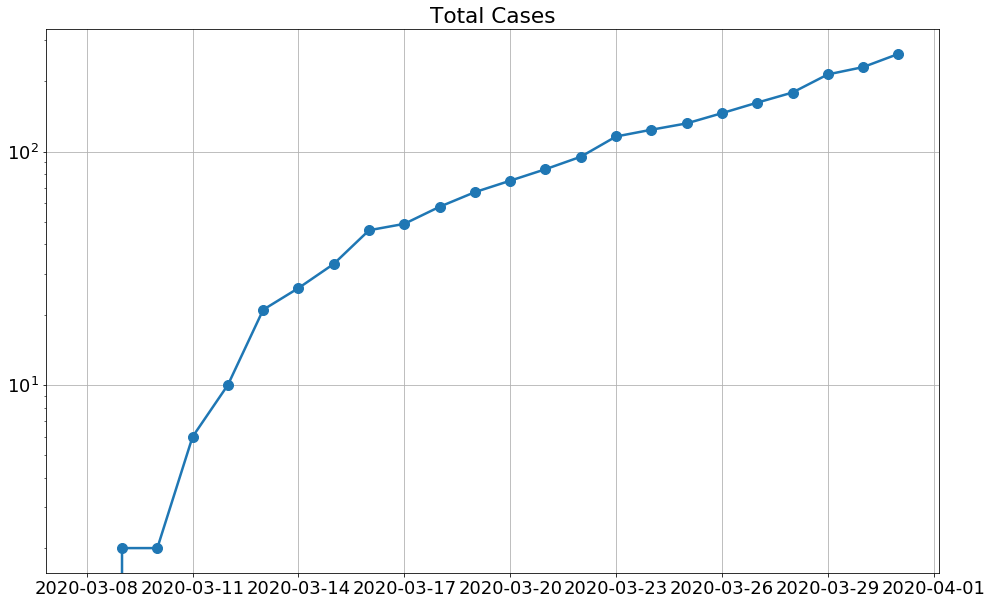

In [6]:
fig = plt.figure(figsize=(16,10))
ax = plt.plot(dates, total_cases, marker="o", markersize=10, linewidth=2.5)
plt.title('Total Cases')
plt.yscale('log')
plt.grid(True)

An exponential function $y=ae^{bx}$, where $a,b$ are constants is a straight line when plotted in logarithmic axes sicnce $\log(y) = log(a) + bx$. This is not the case so far in Cyprus judging by the previous plot. Of course to make conclusions one would need to test this statistically.  

R2 score: 0.9372657634049372


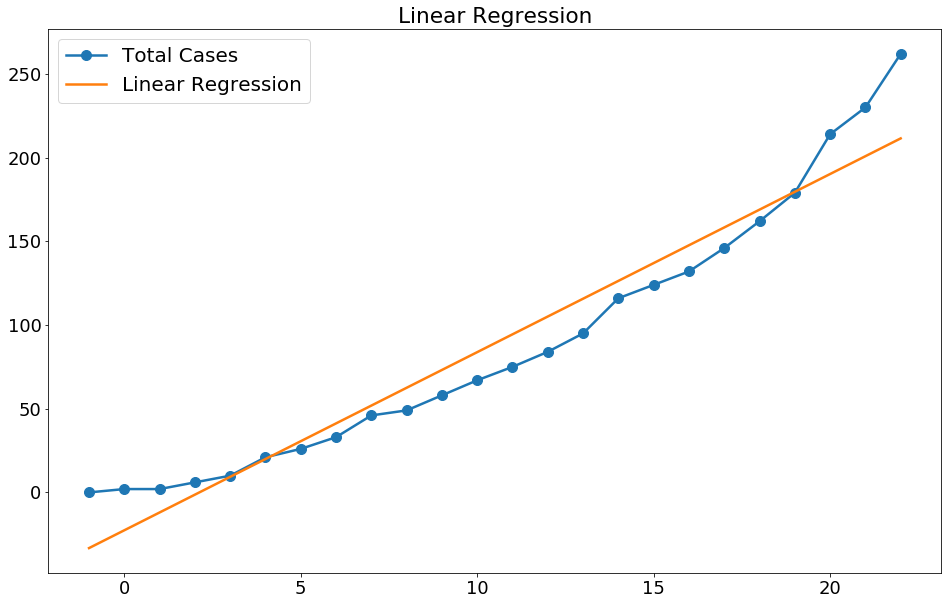

In [7]:
fig = plt.figure(figsize=(16,10))

plt.plot(days_from_onset, total_cases, marker="o", markersize=10, linewidth=2.5, label='Total Cases')

linearReg = LinearRegression().fit(days_from_onset.reshape(-1, 1), total_cases.reshape(-1,1))
#print(linearReg.coef_)
print('R2 score: ' + str(linearReg.score(days_from_onset.reshape(-1,1),total_cases.reshape(-1,1))))

pred = linearReg.predict(days_from_onset.reshape(-1,1))
plt.plot(days_from_onset,pred, linewidth=2.5, label='Linear Regression')
plt.title('Linear Regression')
plt.legend(loc='upper left')

In [8]:
print('Prediction for tomorrow using Linear fit: ' + str(linearReg.predict(days_from_onset[-1]+1)))

Prediction for tomorrow using Linear fit: [[222.16304348]]


R2 score: 0.9966483166956754


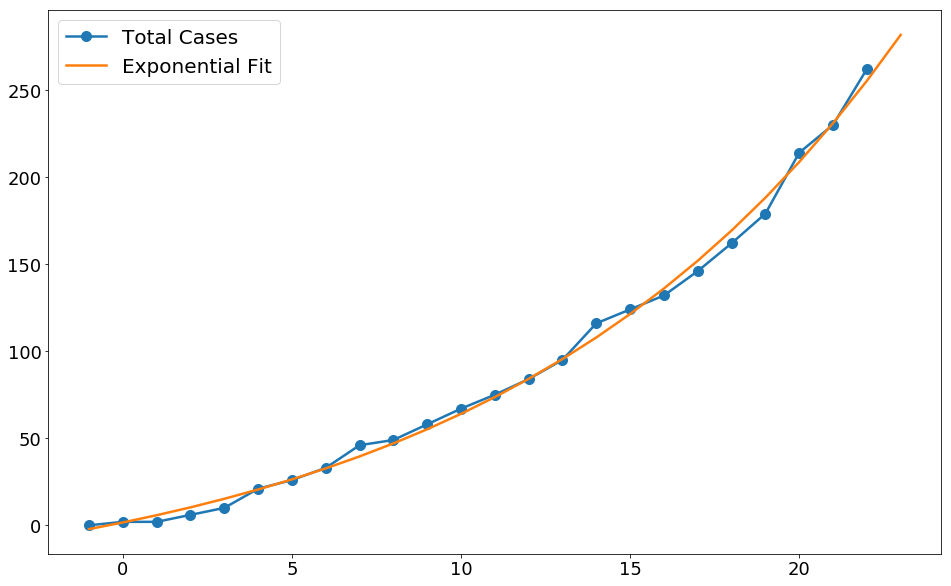

In [9]:
fig = plt.figure(figsize=(16,10))
X_ = np.append(days_from_onset, [days_from_onset[-1]+1])


plt.plot(days_from_onset, total_cases, marker="o", markersize=10, linewidth=2.5, label='Total Cases')

ret = scipy.optimize.curve_fit(lambda t,a,b,c:a*np.exp(b*t)+c, days_from_onset,total_cases, p0 = [0.5,0.2,1])
regC = ret[0]
#print(regC)
a = regC[0]
b = regC[1]
c= regC[2]
prediction = a*np.exp(b*X_) + c
print("R2 score: " + str(sklearn.metrics.r2_score(total_cases, prediction[:len(prediction)-1])))

pred = linearReg.predict(X_.reshape(-1,1))
plt.plot(X_,prediction, linewidth=2.5, label='Exponential Fit')
plt.legend(loc='upper left')

In [10]:
print('Prediction for tomorrow using exponential fit: ' + str(prediction[-1]))

Prediction for tomorrow using exponential fit: 281.6503704663589


In [11]:
scipy.optimize.curve_fit(lambda t,b,c:np.exp(b*t)+c, days_from_onset,total_cases)

(array([ 0.25268184, 40.80112472]), array([[ 1.59355985e-05, -1.43058944e-02],
        [-1.43058944e-02,  4.77255139e+01]]))

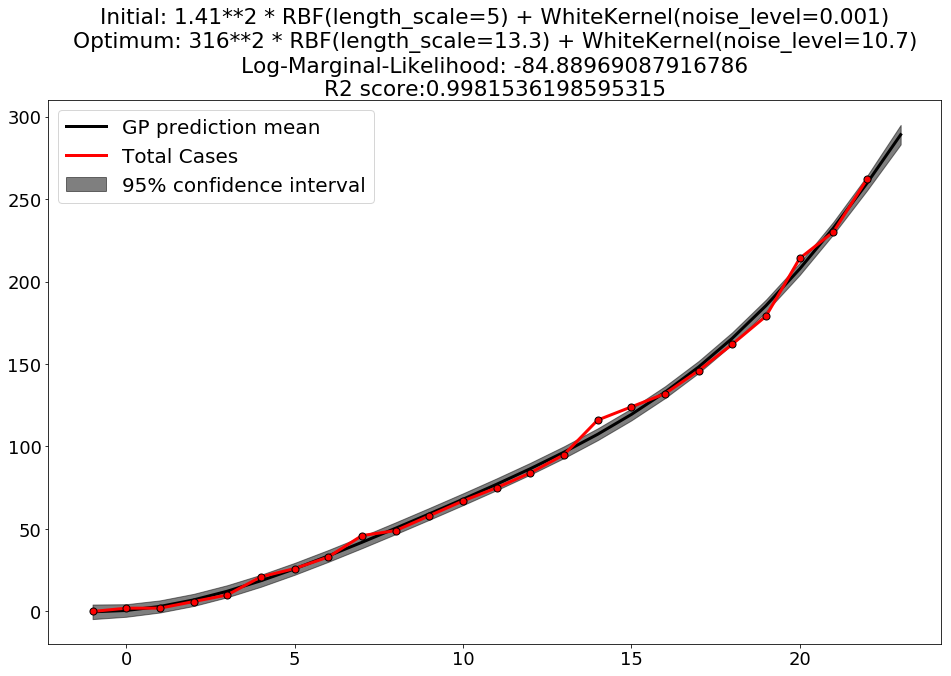

In [12]:
fig = plt.figure(figsize=(16,10))

kernel = 2.0 * RBF(length_scale=5, length_scale_bounds=(1e-4, 1e6)) \
    + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1e+2))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=3).fit(days_from_onset.reshape(-1,1), total_cases)

X_ = np.append(days_from_onset, [days_from_onset[-1]+1]).reshape(-1,1)
y_mean, y_cov = gp.predict(X_, return_cov=True)

plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label='GP prediction mean')
plt.fill_between(X_.flatten(), y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k', label='95% confidence interval')
plt.plot(days_from_onset, total_cases, 'r', lw=3, zorder=9, label='Total Cases')
plt.scatter(days_from_onset, total_cases, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s\nR2 score:%s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta), gp.score(days_from_onset.reshape(-1,1),total_cases)))
plt.legend(loc='upper left')

In [13]:
print('Tomorrow\'s prediction using GP model: ' + str(y_mean[-1]))
print('95% Confidence interval: [' + str(y_mean[-1]-np.sqrt(np.diag(y_cov)[-1])) + ',' 
      + str(y_mean[-1]+np.sqrt(np.diag(y_cov)[-1])) + ']' )
print()

Tomorrow's prediction using GP model: 289.0052239087381
95% Confidence interval: [283.0909780094653,294.91946980801094]



## New Cases Breakdown

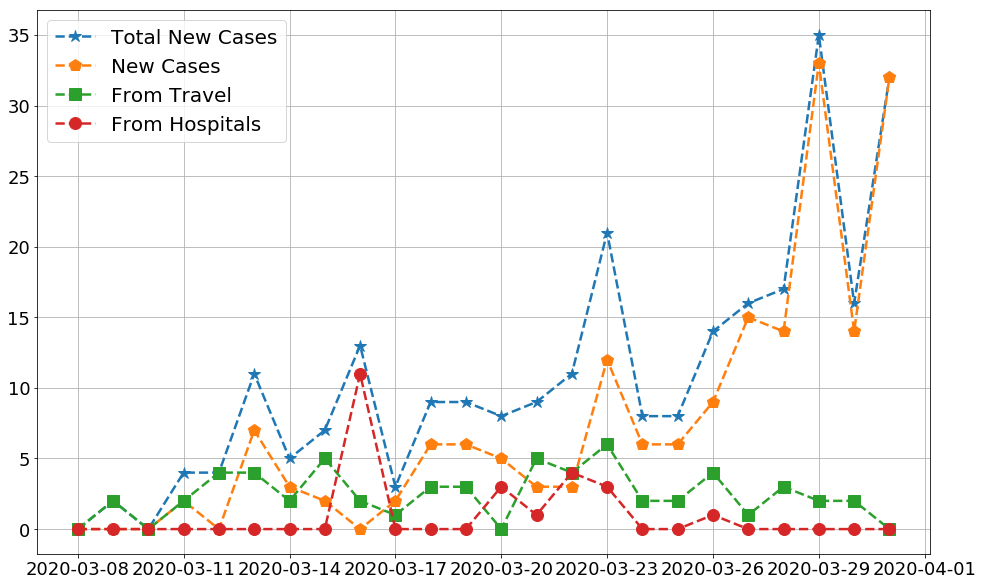

In [14]:
fig = plt.figure(figsize=(16,10))
total_daily_new_cases = np.diff(total_cases)
plt.plot(dates, np.insert(total_daily_new_cases,0,[0]), '*--',  label='Total New Cases')
plt.plot(dates, new_cases, 'p--', label='New Cases')
plt.plot(dates, from_travel, 's--', label='From Travel')
plt.plot(dates, from_hospitals, 'o--', label='From Hospitals')
plt.legend(loc='upper left')
plt.grid(True, 'major')

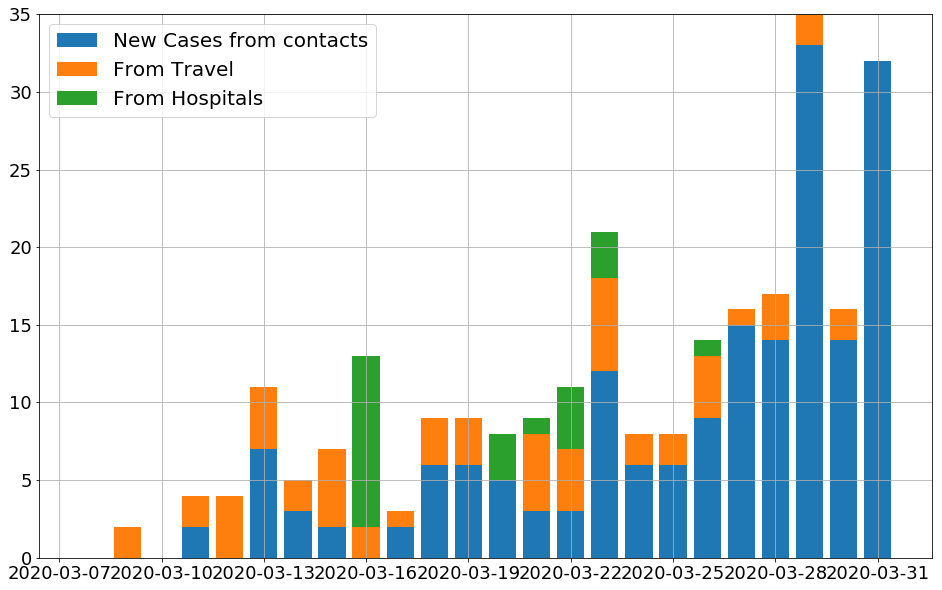

In [15]:
fig = plt.figure(figsize=(16,10))
plt.bar(dates, new_cases, label='New Cases from contacts')
plt.bar(dates, from_travel, bottom=new_cases, label='From Travel')
plt.bar(dates, from_hospitals,bottom=from_travel+new_cases, label='From Hospitals')
plt.legend(loc='upper left')
plt.grid(True, 'major')

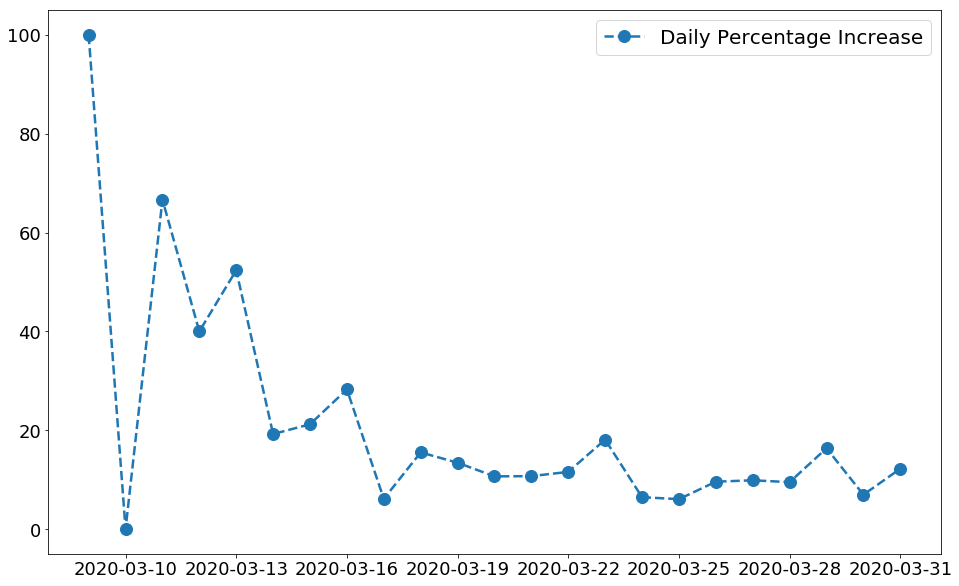

In [16]:
fig = plt.figure(figsize=(16,10))

plt.plot(dates[1:], daily_percentage_increase, 'o--', markersize=12, linewidth=2.5, label='Daily Percentage Increase')
plt.legend(loc='upper right')

[3.09654755 0.09883262]
R2 score: -0.8768348477601158


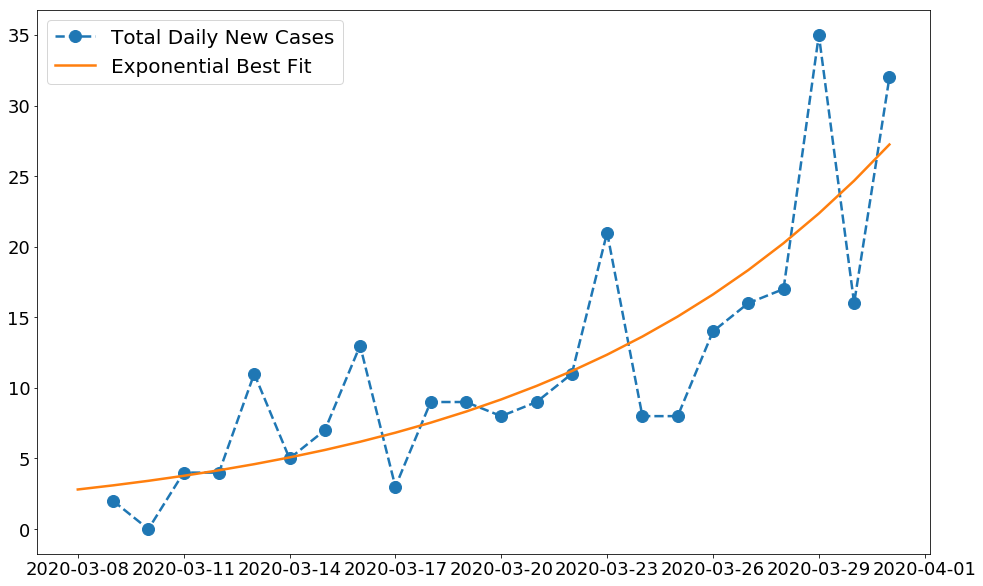

In [17]:
fig = plt.figure(figsize=(16,10))

plt.plot(dates[1:],np.diff(total_cases), 'o--', markersize=12, linewidth=2.5, label='Total Daily New Cases')

ret = scipy.optimize.curve_fit(lambda t,a,b:a*np.exp(b*t), days_from_onset[1:],np.diff(total_cases), p0 = [0.5,0])
regC = ret[0]
print(regC)
a = regC[0]
b = regC[1]
prediction = a*np.exp(b*days_from_onset)
print("R2 score: " + str(sklearn.metrics.r2_score(total_cases, prediction)))

pred = linearReg.predict(days_from_onset.reshape(-1,1))
plt.plot(dates,prediction, linewidth=2.5, label='Exponential Best Fit')


plt.legend(loc='upper left')

In [18]:
print('Prediction for new cases tomorrow using exponential fit: ' + str(a*np.exp(b*(days_from_onset[-1]+1))))

Prediction for new cases tomorrow using exponential fit: 30.067292765225535


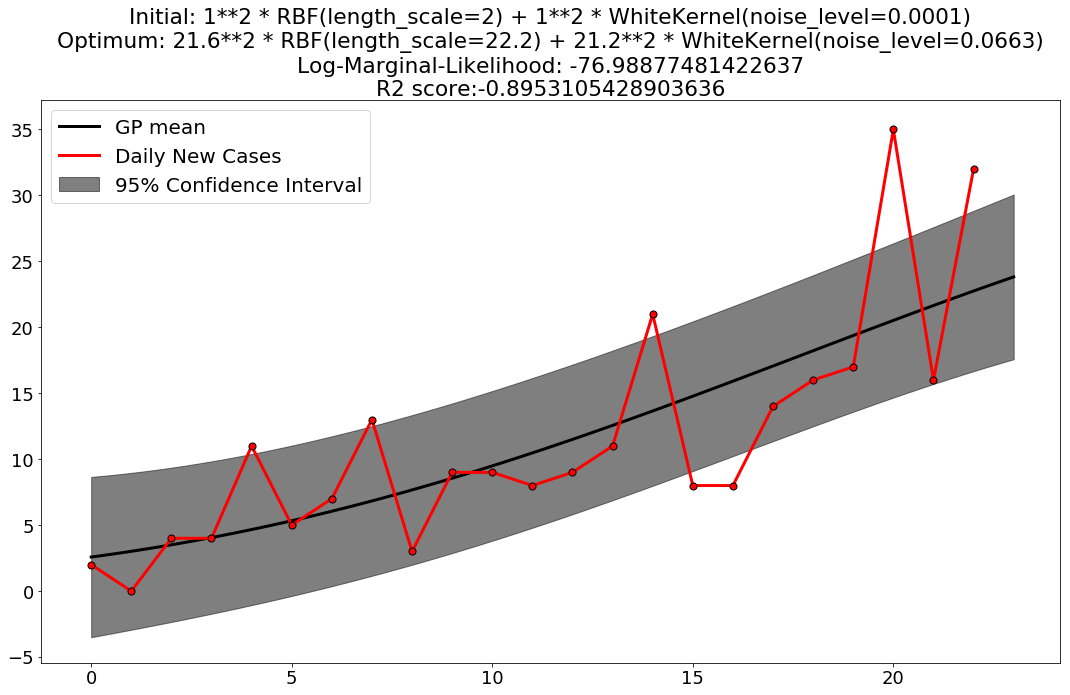

In [25]:
kernel = 1.0 * RBF(length_scale=2, length_scale_bounds=(4,100)) \
        + 1.0 * WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-10, 1e2))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=1).fit(days_from_onset[1:].reshape(-1,1), np.diff(total_cases))

X_ = np.linspace(days_from_onset[1], [days_from_onset[-1]+1],num=100)
y_mean, y_cov = gp.predict(X_.reshape(-1,1), return_cov=True)

fig = plt.figure(figsize=(16,10))
plt.plot(X_.flatten(), y_mean, 'k', lw=3, zorder=9, label='GP mean')
plt.fill_between(X_.flatten(), y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k', label='95% Confidence Interval')
plt.plot(days_from_onset[1:], np.diff(total_cases), 'r', lw=3, zorder=9, label='Daily New Cases')
plt.scatter(days_from_onset[1:], np.diff(total_cases), c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s\nR2 score:%s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta), gp.score(days_from_onset.reshape(-1,1),total_cases)))
plt.tight_layout()
plt.legend(loc='upper left')

In [26]:
print(len(X_.flatten()))
print(len(y_mean))

print(X_.flatten()[:10])
print(y_mean[:10])

100
100
[0.         0.23232323 0.46464646 0.6969697  0.92929293 1.16161616
 1.39393939 1.62626263 1.85858586 2.09090909]
[2.57617436 2.67286039 2.7724799  2.87505619 2.98061125 3.08916574
 3.20073893 3.31534869 3.43301145 3.55374217]


In [27]:
print('Tomorrow\'s prediction using GP model: ' + str(y_mean[-1]))
print('95% Confidence interval: [' + str(y_mean[-1]-np.sqrt(np.diag(y_cov)[-1])) + ',' 
      + str(y_mean[-1]+np.sqrt(np.diag(y_cov)[-1])) + ']' )

Tomorrow's prediction using GP model: 23.821651318293675
95% Confidence interval: [17.5769822680563,30.06632036853105]
